# Raw GSP Spectra
## Graeme Hawker, University of Strathclyde, 13th June 2019

In [133]:
import zipfile
import pandas as pd
import datetime as dt
import numpy as np
import pytz
from scipy.signal import welch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pyplot import cm
import seaborn as sns
#sns.set(rc={'figure.figsize':(11.7,8.27)})
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,10
#plt.rcParams["figure.figsize"] = [20, 5]

In [2]:
def sp_to_dt(SD, SP, period_start=True):
    """
    Converts a settlement date and settlement period to a timezone-aware
    datetime object
    Parameters
    ----------
    SD : datetime.date object
        the settlement date
    SP : int
        the settlement period (in range 1 to 50)
    period_start : bool
        whether the desired datetime object should relate to the start (True)
        or end (False) of the settlement period
    Returns
    -------
    datetime : datetime.datetime
        a timezone-aware datetime object
    """
    #check date object passed - not datetime
    if not isinstance(SD, dt.date):
        raise ValueError('Expected Settlement Date parameter not of type datetime.date')

    #minimum SP value check
    if SP < 1:
        raise ValueError('SP value of %d less than minimum value of 1' % SP)

    #maximum SP value check, taking into account transition days
    transition_days = [dt.date(x.year, x.month, x.day)
                       for x in pytz.timezone('Europe/London')._utc_transition_times]
    if SD in transition_days[::2]: #clocks go forward
        if SP > 46:
            raise ValueError('SP value of %d exceeds maximum value of 46 \
                             for forward clock change date' % SP)
    elif SD in transition_days[1::2]: #clocks go back
        if SP > 50:
            raise ValueError('SP value of %d exceeds maximum value of 50 \
                             for backward clock change date' % SP)
    elif SP > 48:
        raise ValueError('SP value of {} exceeds maximum value of 48 for \
                         non-clock change date {}'.format(SP, SD))

    datetime = dt.datetime(SD.year, SD.month, SD.day, tzinfo=pytz.utc)
    datetime += dt.timedelta(minutes=(SP-1)*30)
    if not period_start:
        datetime += dt.timedelta(minutes=30)

    # DST shift should only be applied on days after transition day
    # (as does not impact calculation until SP resets to 1)
    if SD in transition_days[::2]:
        pass
    elif SD in transition_days[1::2] and SP > 2:
        datetime -= dt.timedelta(hours=1)
    else:
        datetime -= datetime.astimezone(pytz.timezone('Europe/London')).dst()
    return datetime

In [37]:
#paths and constants
GSP_data_path = 'D:/Users/nxb12137/ShareFile/Personal Folders/Elexon Data/GSP Data/p114_gsp_data.zip'
#GSP = 'A_BRAI_1'
GSPs = ['A_ELST_1', 'P_MYBS_P', 'L_INDQ1', 'L_LAND1', 'L_ABHA1', 'L_EXET1']

In [38]:
#extract raw data for given GSP,
#convert settlement dates/periods to timestamps,
#discard unwanted data and sort by time
GSPs_data = {}
for GSP in GSPs:
    with zipfile.ZipFile(GSP_data_path) as z:
        with z.open('{}_gsp_data.csv'.format(GSP.split('_')[0])) as f:
            raw_data = pd.read_csv(f)
            gsp_data = raw_data[raw_data.gsp_id=='_'.join(GSP.split('_')[1:])][['settlement_date', 'settlement_period', 'meter_volume']]
            gsp_data['timestamp'] = gsp_data.apply(lambda row: sp_to_dt(dt.date(int(str(row['settlement_date'])[:4]),
                                                                                    int(str(row['settlement_date'])[4:6]),
                                                                                    int(str(row['settlement_date'])[6:8])),
                                                                        row['settlement_period'], 
                                                                        period_start=True), axis=1)
            GSPs_data[GSP] = gsp_data[['timestamp', 'meter_volume']].set_index('timestamp').sort_index()
            

In [39]:
GSP

'L_EXET1'

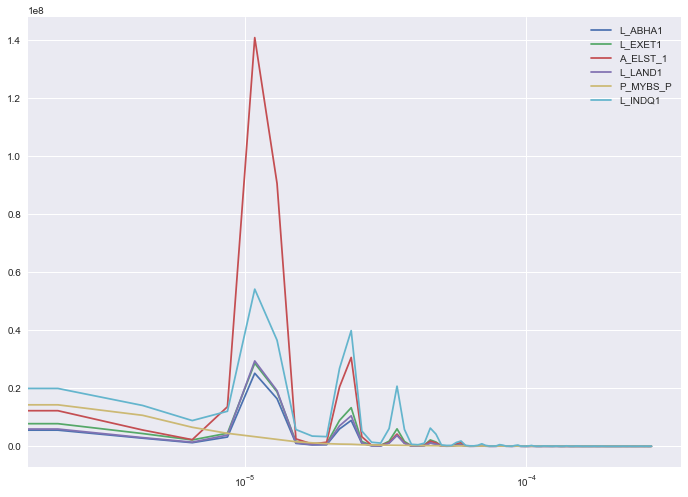

In [50]:
for GSP, gsp_data in GSPs_data.items():
    f, psd = welch(gsp_data['meter_volume'].values,
                   fs = 1/1800.0,
                   window = 'hanning',
                   detrend = 'constant')
    plt.semilogx(f, psd, label=GSP)
    plt.legend()

In [51]:
dict(zip(1/f,psd))

D:\Users\nxb12137\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


{3600.0: 41873.042919267988,
 3628.3464566929138: 24109.193791380018,
 3657.1428571428569: 4017.6552380662201,
 3686.3999999999996: 3977.100104779613,
 3716.1290322580644: 7665.6684412961404,
 3746.3414634146343: 49267.915237050802,
 3777.0491803278687: 32936.561916291648,
 3808.2644628099174: 4324.019124784345,
 3840.0: 3789.4821916205083,
 3872.2689075630256: 4310.4371745267335,
 3905.0847457627115: 36299.976603566844,
 3938.4615384615381: 54649.237158634525,
 3972.4137931034484: 8595.6254310960594,
 4006.9565217391309: 4169.86123540677,
 4042.1052631578946: 4179.3148358279486,
 4077.8761061946902: 13448.527269724536,
 4114.2857142857147: 39908.998865166206,
 4151.3513513513517: 13283.336976161314,
 4189.090909090909: 4555.050024713124,
 4227.5229357798162: 4789.2283202701792,
 4266.666666666667: 8028.9254747084378,
 4306.5420560747662: 42761.506340115884,
 4347.1698113207549: 28799.397455409791,
 4388.5714285714284: 5242.2848360616608,
 4430.7692307692314: 5305.4911776824138,
 4473.

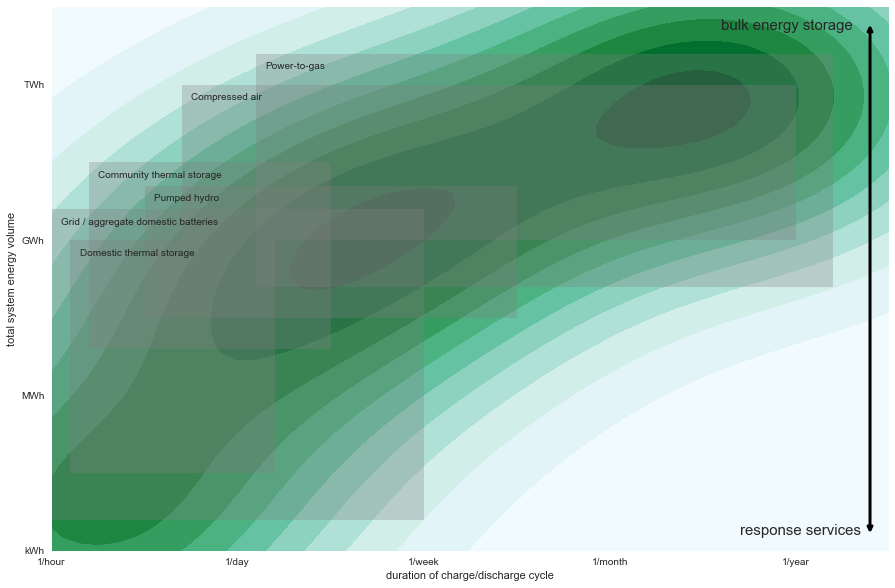

In [162]:
matrix_data = [
    [0.1, 0.1],
    [0.2, 0.1],
    [0.1, 0.2],
    
    [1, 1],
    [1, 1.5],
    [1, 1.8],
    [2, 2.2],
    [2, 2.1],
    [2, 2.5],
    
    [3.5, 3],
    [3.6, 3.1],
    [3.7, 2.9],
    [3.8, 2.8]
    
]

tech_data = {'Pumped hydro': [0.5, 1.5, 2.5, 2.35],
             'Compressed air': [0.7, 2, 4, 3],
             'Power-to-gas': [1.1, 1.7, 4.2, 3.2],
             'Grid / aggregate domestic batteries': [0, 0.2, 2, 2.2],
             'Domestic thermal storage': [0.1, 0.5, 1.2, 2.0],
             'Community thermal storage': [0.2, 1.3, 1.5, 2.5]
            }
             

matrix_df = pd.DataFrame(matrix_data, columns = ['duration of charge/discharge cycle',
                                                 'total system energy volume'])
plot = sns.kdeplot(data=matrix_df['duration of charge/discharge cycle'],
                   data2=matrix_df['total system energy volume'],
                   shade=True)

plot.set_xlim(0, 4.5)
plot.set_ylim(0, 3.5)

plot.set_xticks([0,1,2,3,4])
plot.set_xticklabels(['1/hour', '1/day', '1/week', '1/month', '1/year'])

plot.set_yticks([0,1,2,3])
plot.set_yticklabels(['kWh', 'MWh', 'GWh', 'TWh'])

colors=iter(cm.rainbow(np.linspace(0,1,len(tech_data))))
for tech, coords in tech_data.items():
    color = next(colors)
    plot.add_patch(Rectangle((coords[0], coords[1]),
                             coords[2]-coords[0],
                             coords[3]-coords[1],
                             facecolor='grey',
                             alpha = 0.3))
    plot.annotate(tech,
                  (coords[0]+0.05,
                   coords[3]-0.1),
                  #color=color
                 )
    
plot.annotate(s='', xy=(4.4, 3.4), xytext=(4.4,0.1), arrowprops=dict(arrowstyle='<->', lw=3))
plot.annotate('response services', (3.7, 0.1), fontsize=15)
plot.annotate('bulk energy storage', (3.6, 3.35), fontsize=15)

fig = plot.get_figure()
fig.savefig("matrix_example.svg")